In [ ]:
%pip install arch
%pip install yfinance
from arch.univariate import ConstantMean, GARCH, Normal, arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, gaussian_kde, norm, t
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import math
from statsmodels.graphics.gofplots import qqplot
from scipy.optimize import minimize, Bounds, LinearConstraint, newton
import seaborn as sns
from scipy.integrate import quad
import yfinance as yf


 Part A: Stylised facts and GARCH modelling


[*********************100%***********************]  1 of 1 completed


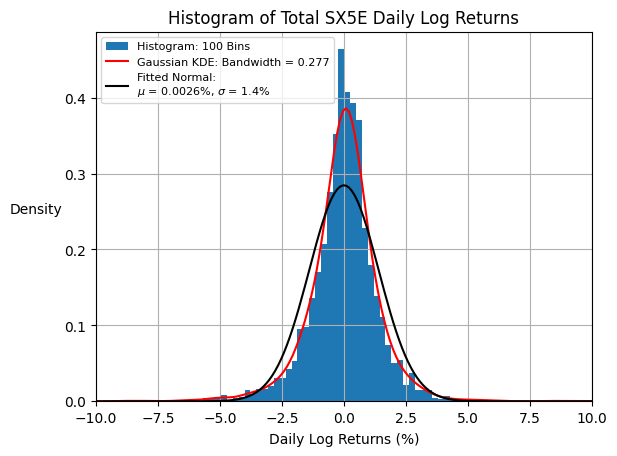

In [ ]:
totaldata = yf.download("^STOXX50E", period = "max")
totaldata['log_return'] = np.log(totaldata['Close']/totaldata['Close'].shift(1))*100
totaldata.dropna(inplace=True)

total_mean = np.mean(totaldata['log_return'])
total_sd = np.std(totaldata['log_return'], ddof=1)


_, bins, _ = plt.hist(totaldata['log_return'], density=True, bins=100, label='Histogram: 100 Bins')
plt.title('Histogram of Total SX5E Daily Log Returns')
plt.ylabel('Density', labelpad=20, rotation=0)
plt.xlabel('Daily Log Returns (%)', labelpad=5)


bandwidth = total_sd*1.06*(len(totaldata)**(-0.2))#formula from lecture slides
kde_estimator = gaussian_kde(totaldata['log_return'], bw_method=bandwidth)
xs = np.linspace(bins[0], bins[-1], 200)
ys1 = kde_estimator(xs)
plt.plot(xs, ys1, c='r', linewidth=1.5, label='Gaussian KDE: Bandwidth = ' + str(round(bandwidth, 3)))

ys2 = norm.pdf(xs, loc=total_mean, scale=total_sd)
plt.xlim((-10,10))
plt.plot(xs, ys2, c='k', linewidth=1.5,
         label='Fitted Normal: \n' + r'$\mu$ = '+str(round(total_mean, 4))+'%' +
         r', $\sigma$ = '+str(round(total_sd, 2))+'%')
plt.legend(fontsize=8, loc=2)
plt.grid()

In [ ]:
url = 'https://raw.githubusercontent.com/HarrisonLam129/QRM1/refs/heads/main/QRM-2024-cw1-data-a.csv'
data = pd.read_csv(url)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, format='%d/%m/%Y')

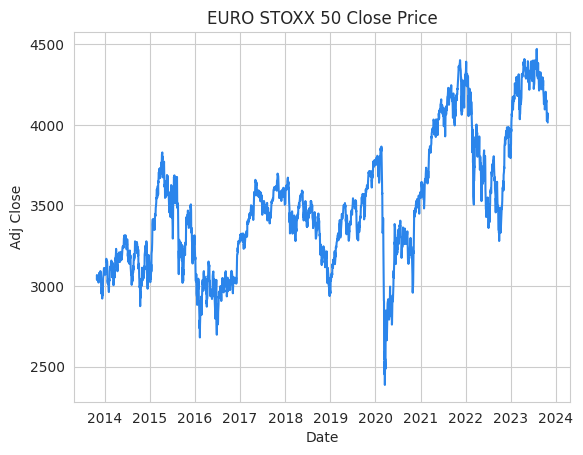

In [ ]:
sns.set_style('whitegrid')
sns.lineplot(data = np.abs(data['Adj Close']), color ="#2B85EB").set(title = 'EURO STOXX 50 Close Price');

(i)

In [ ]:
data['log_return'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))*100
length = len(data.index)
print('Missing values:')
print(data.isnull().sum())
data.dropna(inplace=True)
print('----------------')
print(str(length-len(data.index)), ' data points removed')
print('Length = ', len(data.index))

Missing values:
Adj Close     3
log_return    7
dtype: int64
----------------
7  data points removed
Length =  2505


In [ ]:
sample_mean = np.mean(data['log_return'])
sample_sd = np.std(data['log_return'], ddof=1)
sample_skew = skew(data['log_return'])
sample_kurtosis = kurtosis(data['log_return'])
print('Sample mean: ', round(sample_mean, 4), '%')
print('Sample standard deviation: ', round(sample_sd, 2), '%')
print('Sample skew: ', round(sample_skew, 3))
print('Sample kurtosis: ', round(sample_kurtosis, 1))

Sample mean:  0.0118 %
Sample standard deviation:  1.24 %
Sample skew:  -0.795
Sample kurtosis:  10.3


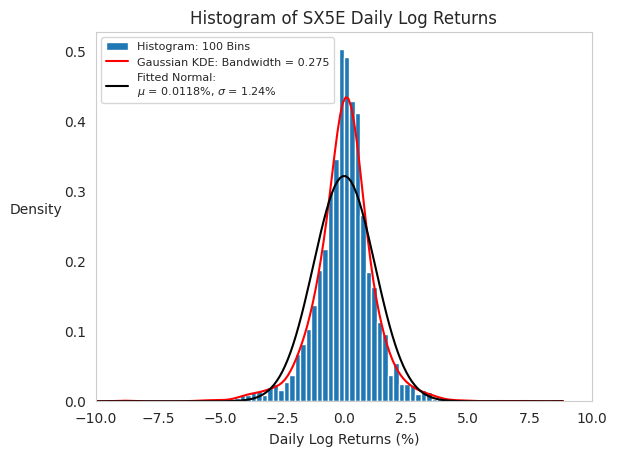

In [ ]:
_, bins, _ = plt.hist(data['log_return'], density=True, bins=100, label='Histogram: 100 Bins')
plt.title('Histogram of SX5E Daily Log Returns')
plt.ylabel('Density', labelpad=20, rotation=0)
plt.xlabel('Daily Log Returns (%)', labelpad=5)


bandwidth = sample_sd*1.06*(len(data)**(-0.2))#formula from lecture slides
kde_estimator = gaussian_kde(data['log_return'], bw_method=bandwidth)
xs = np.linspace(bins[0], bins[-1], 200)
ys1 = kde_estimator(xs)
plt.plot(xs, ys1, c='r', linewidth=1.5, label='Gaussian KDE: Bandwidth = ' + str(round(bandwidth, 3)))

ys2 = norm.pdf(xs, loc=sample_mean, scale=sample_sd)
plt.xlim((-10,10))
plt.plot(xs, ys2, c='k', linewidth=1.5,
         label='Fitted Normal: \n' + r'$\mu$ = '+str(round(sample_mean, 4))+'%' +
         r', $\sigma$ = '+str(round(sample_sd, 2))+'%')
plt.legend(fontsize=8, loc=2)
plt.grid()

The distribution of the daily log returns has a slight negative skew and is leptokurtic (excess kurtosis = 7.3)

(ii)

Text(0, 0.5, 'Autocorrelation')

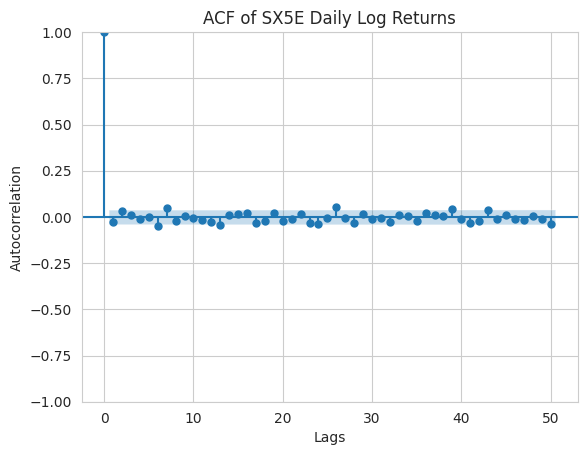

In [ ]:
plot_acf(data['log_return'], lags=50, alpha=0.05)
plt.title('ACF of SX5E Daily Log Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

Log returns seem to be serially uncorrelated for any lag >= 1

Text(0, 0.5, 'Autocorrelation')

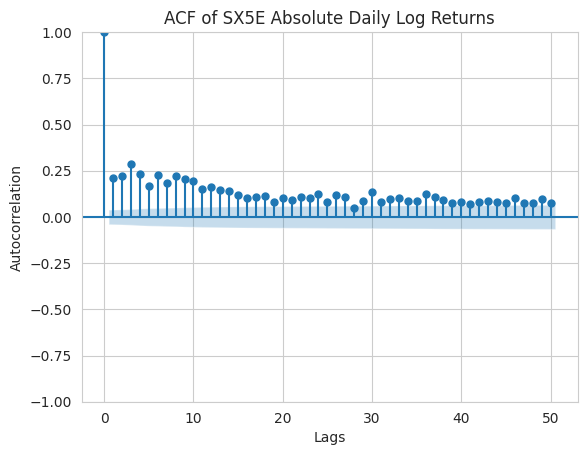

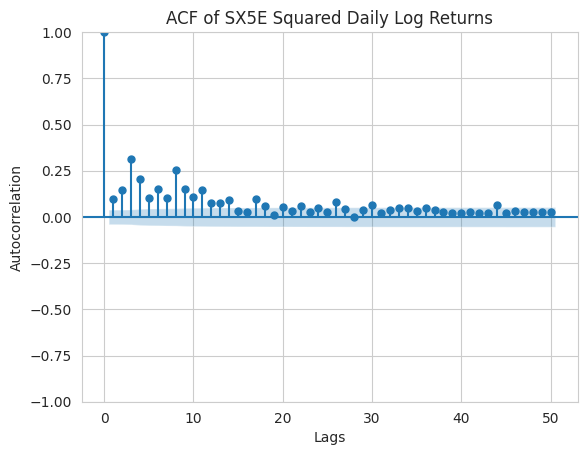

In [ ]:
plot_acf(np.abs(data['log_return']), lags=50, alpha=0.05)
plt.title('ACF of SX5E Absolute Daily Log Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plot_acf(data['log_return']**2, lags=50, alpha=0.05)
plt.title('ACF of SX5E Squared Daily Log Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

Absolute log returns exhibit positive serial correlation, for lags up to 40-50 (high persistence).  Squared log returns also exhibit positive correlation, but is less persistent.  

(iii)

Fit the following model:

$\mathrm{X_t} = {μ} + {σ_tZ_t}: σ_t∼GARCH(1, 1), \quad SWN Z_t∼N(0, 1)$

In [ ]:
x = data["log_return"]
model = arch_model(x)
result = model.fit(update_freq=5)
print(result.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 3798.2886581527537
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3738.9200932811495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3738.9200932811495
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3738.92
Distribution:                  Normal   AIC:                           7485.84
Method:            Maximum Likelihood   BIC:                           7509.14
                                        No. Observations:                 2505
Date:                Thu, Nov 21 2024   Df Residuals:                     2504
Time:       

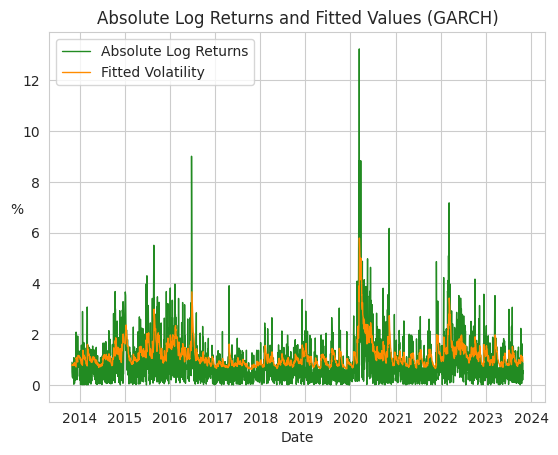

In [ ]:
plt.plot(np.abs(x), c='forestgreen', linewidth=1)
plt.plot(result.conditional_volatility, c='darkorange', linewidth=1)
plt.title('Absolute Log Returns and Fitted Values (GARCH)')
plt.xlabel('Date')
plt.ylabel('%', rotation=0)
plt.grid(True)
plt.legend(['Absolute Log Returns', 'Fitted Volatility'])
plt.savefig('GARCH.png')

(iv)

We observe that there are peaks in fitted volatility whenever the absolute log returns are large, which suggests that our implementation is correct.  We are also able to capture volatility clustering (periods of high/low volatility), and persistence, which is particularly evident in the volatility spike at the start of 2020.

We look at standardised residuals $\mathrm {Z_t = \frac {X_t-μ}{σ_t}}$, which should have a $\mathrm N(0, 1)$ distribution by our model assumptions.  To evaluate this assumptions, we evalute the following diagnostic plots:

Scale-Location: \\
Under standard GARCH assumptions, $\mathrm (Z_t)$ should be a strict white noise process that is independent from $X_t$ and $σ_t$.  However, observations with smaller fitted volatilities seem to have standardised residuals that are much larger in magnitude.  \\
One of the reasons is that our model cannot account for the impact of intraday shocks in the market (e.g. press releases during the day), in which case, the shock is not reflected in the previous period return and will not affect the fitted volatility for the current period.  This results in 'unpredictable' jumps in absolute returns, hence the extreme residuals for small fitted values.  \\
Another reason could be that we are not properly capturing the persistence in the GARCH model, which causes the fitted volatility to decay too quickly.  Alternatively, this could also be captured using a different mean model, \\
e.g. an ARMA(1, 1) model with $θ_i$ or $ϕ_i$ close to 1.

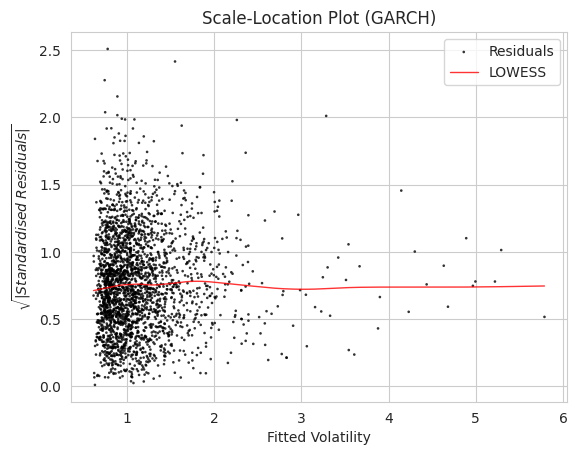

In [ ]:
standard_residuals = result.resid/result.conditional_volatility
sns.regplot(x=result.conditional_volatility, y=np.sqrt(abs(standard_residuals)),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (GARCH)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS'])

QQ Plot: \\
From this plot, we observe that the distribution of the standardised residuals is leptokurtic, which results in residuals that are much more extreme than expected under $\mathrm Z_t\sim N(0, 1)$. \\
However, this does not necessarily contradict the normality assumption of the errors, as this might simply be an effect of the data frequency or persistence underestimation issue, discovered above in the scale-location plot.

Text(0, 0.5, 'Sample Quantiles of Standardised Residuals')

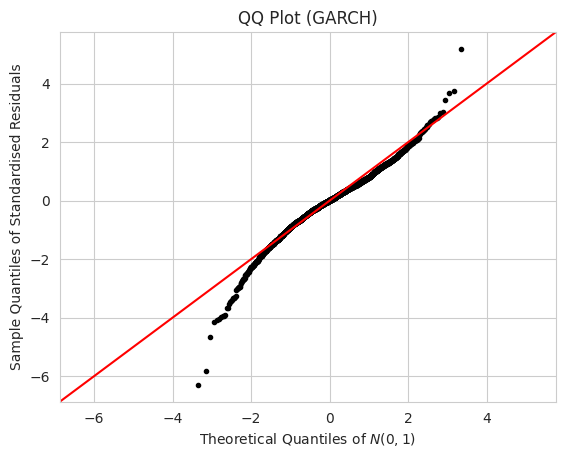

In [ ]:
qqplot(standard_residuals, norm, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('QQ Plot (GARCH)')
plt.xlabel(r'Theoretical Quantiles of $N(0, 1)$');
plt.ylabel('Sample Quantiles of Standardised Residuals')

ACF Plot: \\
In both the ACF plots, we observe that the standardised residuals and the standardised residuals squared are both serially uncorrelated, which aligns with the modelling assumption that $\mathrm Z_t∼N(0, 1)$ is a strict white noise process.

Text(0, 0.5, 'Autocorrelation')

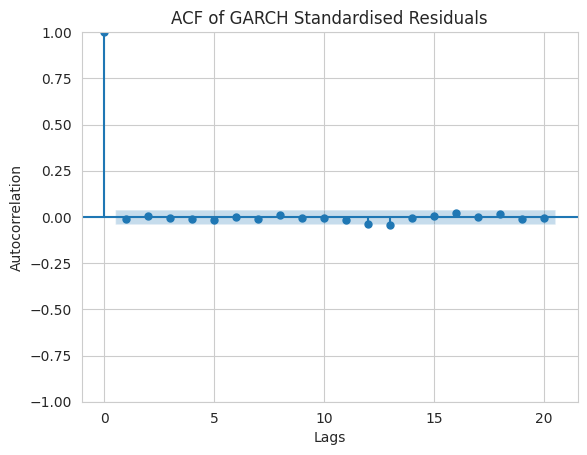

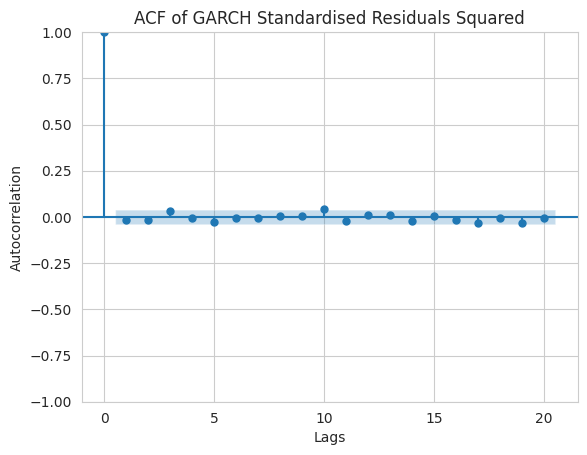

In [ ]:
plot_acf(standard_residuals, lags=20, alpha=0.05)
plt.title('ACF of GARCH Standardised Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plot_acf(standard_residuals**2, lags=20, alpha=0.05)
plt.title('ACF of GARCH Standardised Residuals Squared')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

(v)

In [ ]:
def arma_garch_t(a0, a1, b1, mu, phi1, theta1, nu, x):
    for i in range(1, len(x)):
        mean[i] = mu + phi1*(x.iat[i-1]-mu) + theta1*(x.iat[i-1]-mean[i-1])
        variance[i] = a0 + a1*(x.iat[i-1]-mean[i-1])**2 + b1*variance[i-1]
    return np.sum(-0.5*np.log(variance[1:]) + np.log(t.pdf((x.iloc[1:]-mean[1:])/np.sqrt(variance[1:]), df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))

variance = np.zeros_like(x)
mean = np.zeros_like(x)
variance[0] = np.var(x, ddof=1)
mean[0] = np.mean(x)
y0 = [1, 0.01, 0.01, 0, 0, 0, 5]
range_constraint = [[0, np.inf], [0, 1], [0, 1], [-10, 10], [-np.inf, np.inf], [-np.inf, np.inf], [2, np.inf]]
linear_constraint = LinearConstraint([0, 1, 1, 0, 0, 0, 0], lb=0, ub=1)
maxLL = minimize(lambda y: -arma_garch_t(y[0], y[1], y[2], y[3], y[4], y[5], y[6], x),
                 y0, method='SLSQP',
                 bounds=range_constraint, constraints=linear_constraint, options={'disp': True})

<ipython-input-17-c33681a6ab65>:4: RuntimeWarning: overflow encountered in scalar power
  variance[i] = a0 + a1*(x.iat[i-1]-mean[i-1])**2 + b1*variance[i-1]
<ipython-input-17-c33681a6ab65>:3: RuntimeWarning: overflow encountered in scalar multiply
  mean[i] = mu + phi1*(x.iat[i-1]-mu) + theta1*(x.iat[i-1]-mean[i-1])
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-17-c33681a6ab65>:4: RuntimeWarning: invalid value encountered in scalar multiply
  variance[i] = a0 + a1*(x.iat[i-1]-mean[i-1])**2 + b1*variance[i-1]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3635.092242296304
            Iterations: 50
            Function evaluations: 447
            Gradient evaluations: 50


In [ ]:
print('a0: ', round(maxLL.x[0], 8))
print('a1: ', round(maxLL.x[1], 3))
print('b1: ', round(maxLL.x[2], 3))
print('mu: ', round(maxLL.x[3], 3))
print('phi1: ', round(maxLL.x[4], 3))
print('theta1: ', round(maxLL.x[5], 3))
print('nu: ', round(maxLL.x[6], 3))

a0:  0.0474542
a1:  0.148
b1:  0.834
mu:  0.07
phi1:  0.911
theta1:  -0.934
nu:  4.727


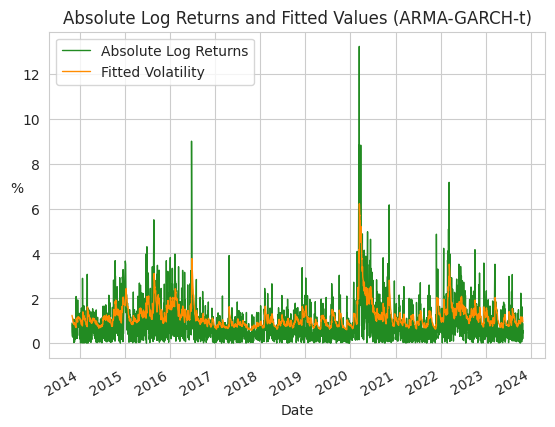

In [ ]:
plt.plot(np.abs(x), linewidth=1, c='forestgreen')
fitted_volatility = pd.Series(np.sqrt(variance), index=data.index)
fitted_volatility.plot(linewidth=1, c='darkorange')

plt.title('Absolute Log Returns and Fitted Values (ARMA-GARCH-t)')
plt.xlabel('Date')
plt.ylabel('%', rotation=0)
plt.grid(True)
plt.legend(['Absolute Log Returns', 'Fitted Volatility'])
plt.savefig('ARMA-GARCH-t.png')

Plotting the same diagnostic plots as before:

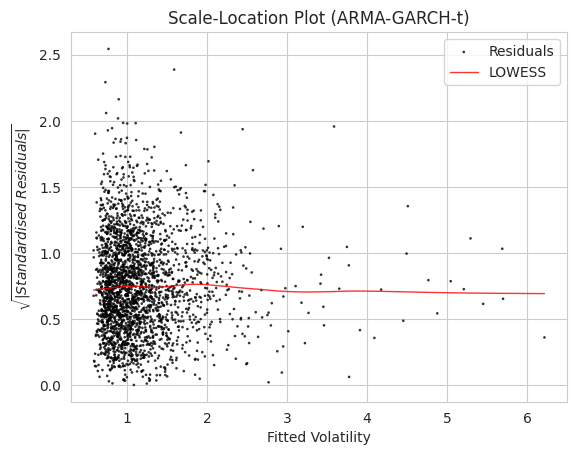

In [ ]:
arma_garch_t_standard_residuals = (x-mean)/np.sqrt(variance)
sns.regplot(x=np.sqrt(variance), y=np.sqrt(abs(arma_garch_t_standard_residuals)),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (ARMA-GARCH-t)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS'])
plt.savefig('ARMA-GARCH-t ScaleLoc.png')

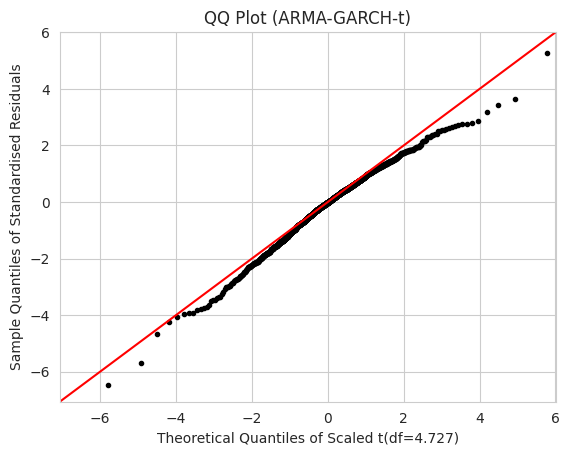

In [ ]:
qqplot(arma_garch_t_standard_residuals, t(df=maxLL.x[6], scale=np.sqrt((maxLL.x[6]-2)/maxLL.x[6])), line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('QQ Plot (ARMA-GARCH-t)')
plt.xlabel(f'Theoretical Quantiles of Scaled t(df={round(maxLL.x[6], 3)})')
plt.ylabel('Sample Quantiles of Standardised Residuals');
plt.savefig('ARMA-GARCH-t QQ.png')

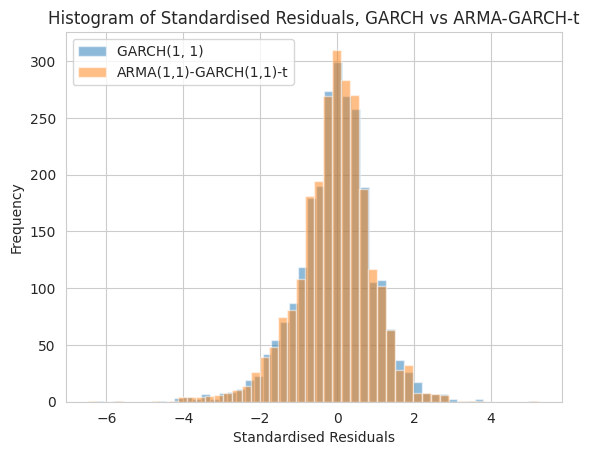

In [ ]:
plt.hist(standard_residuals, bins=50, alpha=0.5)
plt.hist(arma_garch_t_standard_residuals, bins=50, alpha=0.5)
plt.title('Histogram of Standardised Residuals, GARCH vs ARMA-GARCH-t')
plt.xlabel('Standardised Residuals')
plt.ylabel('Frequency')
plt.legend(['GARCH(1, 1)', 'ARMA(1,1)-GARCH(1,1)-t']);

ACF Plot: \\
Adding an ARMA component seems to introduce some serial correlation into the standardised residuals.

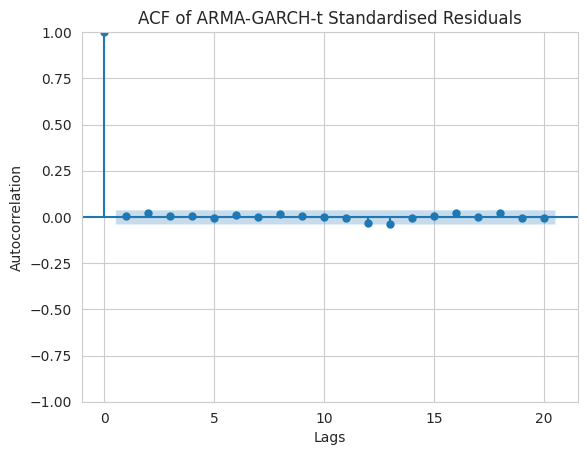

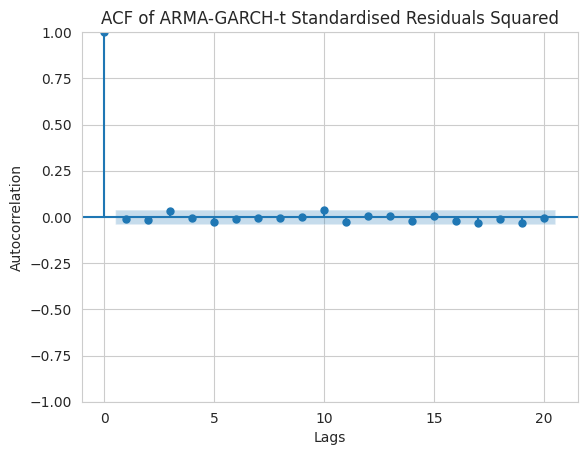

In [ ]:
plot_acf(arma_garch_t_standard_residuals, lags=20, alpha=0.05)
plt.title('ACF of ARMA-GARCH-t Standardised Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('ARMA-GARCH-t residual')

plot_acf(arma_garch_t_standard_residuals**2, lags=20, alpha=0.05)
plt.title('ACF of ARMA-GARCH-t Standardised Residuals Squared')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('ARMA-GARCH-t residual squared')

### Implementing GARCH-t and ARMA-GARCH-t with a skewed t-distribution
A. Azzalini: The Skew-Normal and Related Families (Chapter 3)

In [ ]:
def garch_t_skewed(a0, a1, b1, mu, nu, x):
    for i in range(1, len(x)):
        variance[i] = a0 + a1*(x.iat[i-1]-mean)**2 + b1*variance[i-1]
    return np.sum(-0.5*np.log(variance[1:]) + np.log(2) +
                  np.log(t.pdf((x.iloc[1:]-mean)/np.sqrt(variance[1:]), df=nu, loc=0, scale=np.sqrt((nu-2)/nu))) +
                  np.log(t.cdf(alpha*(x.iloc[1:]-mean)/np.sqrt(variance[1:]), df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))

alpha = 0.2
variance = np.zeros_like(x)
variance[0] = np.var(x, ddof=1)
mean = np.mean(x)
y0 = [1, 0.01, 0.01, 0, 5]
range_constraint = [[0, np.inf], [0, 1], [0, 1], [-np.inf, np.inf], [2, np.inf]]
linear_constraint = LinearConstraint([0, 1, 1, 0, 0], lb=0, ub=1)
maxLL = minimize(lambda y: -garch_t_skewed(y[0], y[1], y[2], y[3], y[4], x),
                 y0, method='SLSQP',
                 bounds=range_constraint, constraints=linear_constraint, options={'disp': True})

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3694.0676038233833
            Iterations: 20
            Function evaluations: 137
            Gradient evaluations: 20


In [ ]:
print('a0: ', round(maxLL.x[0], 8))
print('a1: ', round(maxLL.x[1], 3))
print('b1: ', round(maxLL.x[2], 3))
print('mu: ', round(maxLL.x[3], 3))
print('nu: ', round(maxLL.x[4], 3))

a0:  0.05187674
a1:  0.144
b1:  0.836
mu:  0.0
nu:  5.386


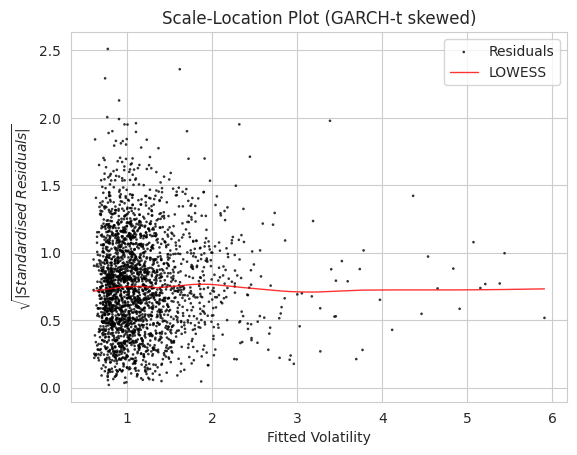

In [ ]:
garch_t_skewed_standard_residuals = (x-mean)/np.sqrt(variance)
sns.regplot(x=np.sqrt(variance), y=np.sqrt(abs(garch_t_skewed_standard_residuals)),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (GARCH-t skewed)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS']);

0
10
20
30
40
50


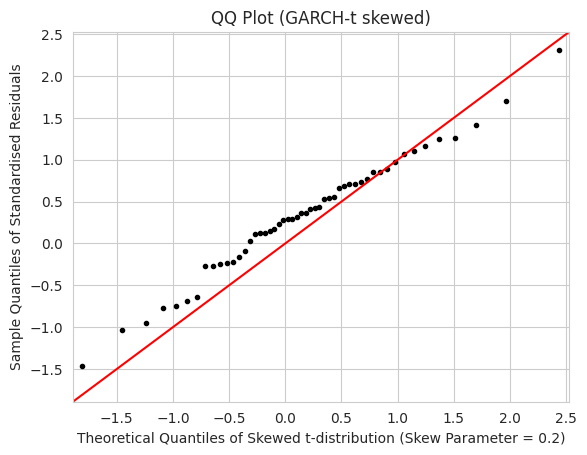

In [ ]:
class SkewedT:
    def __init__(self, alpha, nu):
        self.alpha = alpha
        self.nu = nu
        self.name = 'SkewedT'

    def pdf(self, x):
        scaling = 2*t.cdf(self.alpha*x, df=self.nu, scale=np.sqrt((self.nu-2)/self.nu))
        return t.pdf(x, df=self.nu, scale=np.sqrt((self.nu-2)/self.nu))*scaling

    def cdf(self, x):
        result = quad(lambda val: self.pdf(val), -np.inf, x)
        return result[0]

    def ppf(self, q):
        output = []
        for i, elem in enumerate(q):
            output.append(newton(lambda x: self.cdf(x)-elem, 1/2))
            if i%10 == 0:
                print(i)
        return np.array(output)

skewed_t = SkewedT(alpha, maxLL.x[4])
qqplot(garch_t_skewed_standard_residuals[::50], skewed_t, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title(f'QQ Plot (GARCH-t skewed)')
plt.xlabel(f'Theoretical Quantiles of Skewed t-distribution (Skew Parameter = {alpha})')
plt.ylabel('Sample Quantiles of Standardised Residuals');

### ARMA-GARCH-t skewed

In [ ]:
def arma_garch_t_skewed(a0, a1, b1, mu, phi1, theta1, nu, x):
    for i in range(1, len(x)):
        mean[i] = mu + phi1*(x.iat[i-1]-mu) + theta1*(x.iat[i-1]-mean[i-1])
        variance[i] = a0 + a1*(x.iat[i-1]-mean[i-1])**2 + b1*variance[i-1]
    return np.sum(-0.5*np.log(variance[1:]) + np.log(2) +
                  np.log(t.pdf((x.iloc[1:]-mean[1:])/np.sqrt(variance[1:]), df=nu, loc=0, scale=np.sqrt((nu-2)/nu))) +
                  np.log(t.cdf(alpha*(x.iloc[1:]-mean[1:])/np.sqrt(variance[1:]), df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))

alpha = 0
variance = np.zeros_like(x)
mean = np.zeros_like(x)
variance[0] = np.var(x, ddof=1)
mean[0] = np.mean(x)
y0 = [1, 0.01, 0.01, 0, 0, 0, 5]
range_constraint = [[0, np.inf], [0, 1], [0, 1], [-np.inf, np.inf], [-np.inf, np.inf], [-np.inf, np.inf], [2, np.inf]]
linear_constraint = LinearConstraint([0, 1, 1, 0, 0, 0, 0], lb=0, ub=1)
maxLL = minimize(lambda y: -arma_garch_t_skewed(y[0], y[1], y[2], y[3], y[4], y[5], y[6], x),
                 y0, method='SLSQP',
                 bounds=range_constraint, constraints=linear_constraint, options={'disp': True})

<ipython-input-28-2cd495fc9967>:4: RuntimeWarning: overflow encountered in scalar power
  variance[i] = a0 + a1*(x.iat[i-1]-mean[i-1])**2 + b1*variance[i-1]
<ipython-input-28-2cd495fc9967>:3: RuntimeWarning: overflow encountered in scalar multiply
  mean[i] = mu + phi1*(x.iat[i-1]-mu) + theta1*(x.iat[i-1]-mean[i-1])
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-28-2cd495fc9967>:4: RuntimeWarning: invalid value encountered in scalar multiply
  variance[i] = a0 + a1*(x.iat[i-1]-mean[i

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3635.09224261905
            Iterations: 53
            Function evaluations: 478
            Gradient evaluations: 53


In [ ]:
print('a0: ', round(maxLL.x[0], 8))
print('a1: ', round(maxLL.x[1], 3))
print('b1: ', round(maxLL.x[2], 3))
print('mu: ', round(maxLL.x[3], 3))
print('phi1: ', round(maxLL.x[4], 3))
print('theta1: ', round(maxLL.x[5], 3))
print('nu: ', round(maxLL.x[6], 3))

a0:  0.0474496
a1:  0.148
b1:  0.834
mu:  0.07
phi1:  0.911
theta1:  -0.933
nu:  4.727


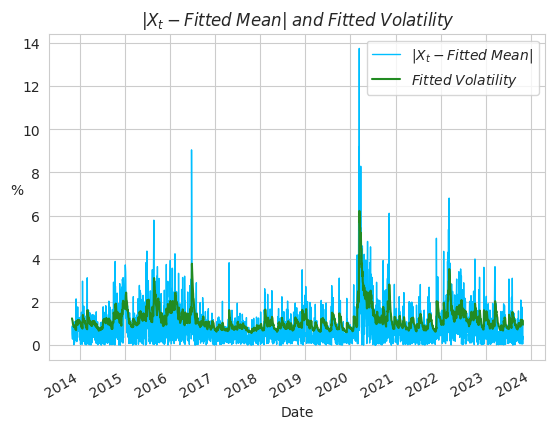

In [ ]:
plt.plot(abs(x-mean), linewidth=1, c='deepskyblue')
fitted_volatility = pd.Series(np.sqrt(variance), index=data.index)
fitted_volatility.plot(linewidth=1.5, c='forestgreen')
plt.title(r'$|X_t-Fitted\; Mean|\; and\; Fitted\; Volatility$')
plt.legend([r'$|X_t-Fitted\; Mean|$', r'$Fitted\; Volatility$'])
plt.ylabel('%', rotation=0);

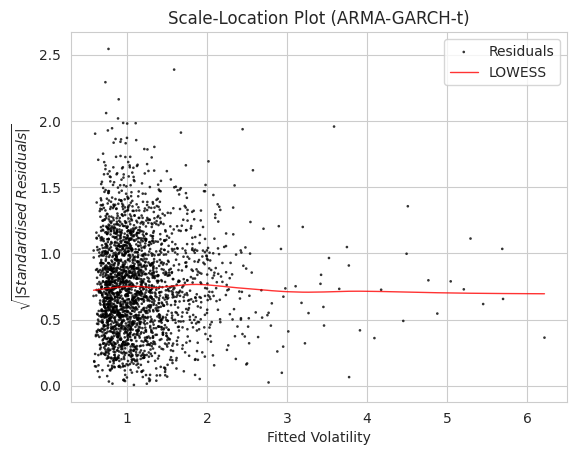

In [ ]:
arma_garch_t_skewed_standard_residuals = (x-mean)/np.sqrt(variance)
sns.regplot(x=np.sqrt(variance), y=np.sqrt(abs(arma_garch_t_skewed_standard_residuals)),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (ARMA-GARCH-t)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS']);

0
10
20
30
40
50


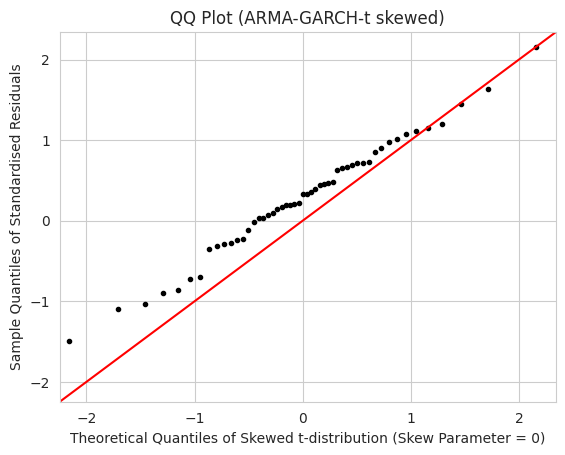

In [ ]:
skewed_t = SkewedT(alpha, maxLL.x[6])
qqplot(arma_garch_t_skewed_standard_residuals[::50], skewed_t, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title(f'QQ Plot (ARMA-GARCH-t skewed)')
plt.xlabel(f'Theoretical Quantiles of Skewed t-distribution (Skew Parameter = {alpha})')
plt.ylabel('Sample Quantiles of Standardised Residuals');

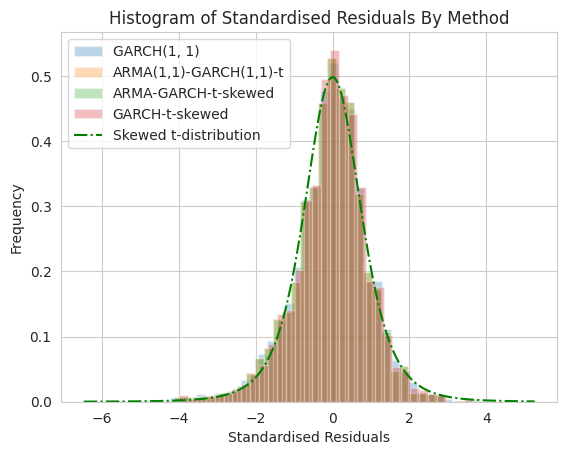

In [ ]:
plt.hist(standard_residuals, bins=50, alpha=0.3, density=True, label='GARCH(1, 1)')
plt.hist(arma_garch_t_standard_residuals, bins=50, alpha=0.3, density=True, label='ARMA(1,1)-GARCH(1,1)-t')
plt.hist(arma_garch_t_skewed_standard_residuals, bins=50, alpha=0.3, density=True, label='ARMA-GARCH-t-skewed')
plt.hist(garch_t_skewed_standard_residuals, bins=50, alpha=0.3, density=True, label='GARCH-t-skewed')

xs = np.linspace(min(arma_garch_t_skewed_standard_residuals), max(arma_garch_t_skewed_standard_residuals), 200)
ys = []
for val in xs:
    ys.append(skewed_t.pdf(val))
plt.plot(xs, ys, label='Skewed t-distribution', c='g', linestyle='-.')

plt.title('Histogram of Standardised Residuals By Method')
plt.xlabel('Standardised Residuals')
plt.ylabel('Frequency')
plt.legend();

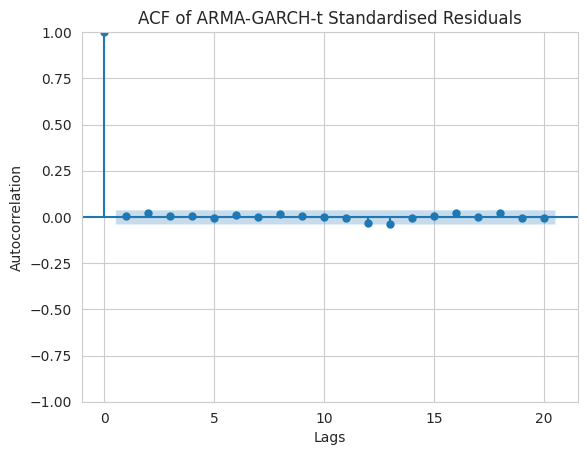

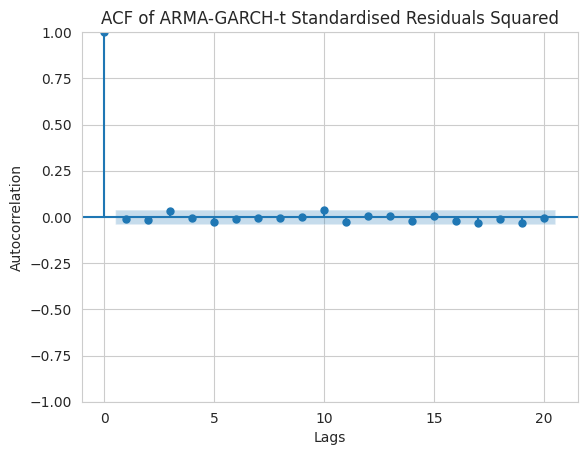

In [ ]:
plot_acf(arma_garch_t_skewed_standard_residuals, lags=20, alpha=0.05)
plt.title('ACF of ARMA-GARCH-t Standardised Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plot_acf(arma_garch_t_skewed_standard_residuals**2, lags=20, alpha=0.05)
plt.title('ACF of ARMA-GARCH-t Standardised Residuals Squared')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation');

--------------------------------------------------------------------------------
# **Part B**

(i) Historical Simulation

In [ ]:
url = 'https://raw.githubusercontent.com/HarrisonLam129/QRM1/refs/heads/main/QRM-2024-cw1-data-b.csv'
data2 = pd.read_csv(url)
data2 = data2.set_index('Date')
data2.index = pd.to_datetime(data2.index, format='%d/%m/%Y')
data2['log_return'] = np.log(data2['Adj Close']/data2['Adj Close'].shift(1))*100
data2.dropna(inplace=True)

In [ ]:
def HS(row):
    row_index = data2.index.get_loc(row.name)
    if row_index <= 499:
        var95, var99, es95, es99 = np.nan, np.nan, np.nan, np.nan
    else:
        past_losses = -data2['log_return'].iloc[row_index-500: row_index]
        past_losses.sort_values(inplace=True)
        var95, var99 = np.quantile(past_losses, 0.95), np.quantile(past_losses, 0.99)
        es95 = past_losses.loc[past_losses >= var95].mean()
        es99 = past_losses.loc[past_losses >= var99].mean()
    row['var95'] = var95
    row['var99'] = var99
    row['es95'] = es95
    row['es99'] = es99
    return row

data2['loss'] = -data2['log_return']
data2 = data2.apply(HS, axis=1);
data2.tail()

,Adj Close,log_return,loss,var95,var99,es95,es99
Date,,,,,,,
2023-10-23,34.049999,0.618647,-0.618647,1.731372,2.730395,2.302237,3.01516
2023-10-24,33.840000,-0.618647,0.618647,1.731372,2.730395,2.302237,3.01516
2023-10-25,33.959999,0.353980,-0.353980,1.731372,2.730395,2.302237,3.01516
2023-10-26,34.250000,0.850323,-0.850323,1.731372,2.730395,2.302237,3.01516
2023-10-27,34.639999,1.132249,-1.132249,1.731372,2.730395,2.302237,3.01516


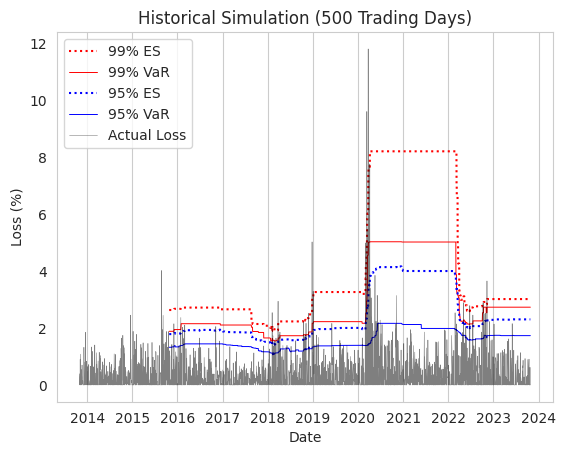

In [ ]:
plt.plot(data2['es99'], c='r', linestyle=':')
plt.plot(data2['var99'], c='r', linewidth=0.7)
plt.plot(data2['es95'], c='b', linestyle=':')
plt.plot(data2['var95'], c='b', linewidth=0.7)
plt.plot(np.maximum(data2['loss'], 0), c='k', linewidth=0.4, alpha=0.5)
plt.title('Historical Simulation (500 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Loss (%)')
plt.legend(['99% ES', '99% VaR', '95% ES', '95% VaR', 'Actual Loss'], loc=2)
plt.grid(axis='y')

(ii) Filtered Historical Simulation

In [ ]:
#code for recursive calculation without 500 day running window
#used total sample variance as reasonabel starting value for sigma_hat_0
alpha = 0.06
mu_t=0

ewma_variance = np.full(len(data2), np.nan)

initial_variance = data2['log_return'].var()
print(np.sqrt(initial_variance))
ewma_variance[0] = initial_variance

for t in range(1, len(data2)):
    previous_loss = -data2['log_return'].iloc[t-1]
    ewma_variance[t] = alpha * ((previous_loss-mu_t) ** 2) + (1 - alpha) * ewma_variance[t-1]

ewma_volatility = np.sqrt(ewma_variance)

data2['ewma_variance'] = ewma_variance
data2['ewma_volatility'] = ewma_volatility

data2.iloc[497:503]

1.0910037633146554


,Adj Close,log_return,loss,var95,var99,es95,es99,ewma_variance,ewma_volatility
Date,,,,,,,,,
2015-10-22,85.912857,-1.873272,1.873272,NaN,NaN,NaN,NaN,1.032566,1.016153
2015-10-23,85.081673,-0.972184,0.972184,NaN,NaN,NaN,NaN,1.181161,1.086812
2015-10-26,85.232819,0.177491,-0.177491,NaN,NaN,NaN,NaN,1.167000,1.080278
2015-10-27,85.459496,0.265597,-0.265597,1.322315,1.88343,1.783492,2.631404,1.098870,1.048270
2015-10-28,84.439423,-1.200814,1.200814,1.322315,1.88343,1.783492,2.631404,1.037170,1.018416
2015-10-29,84.552757,0.134129,-0.134129,1.322315,1.88343,1.783492,2.631404,1.061458,1.030271


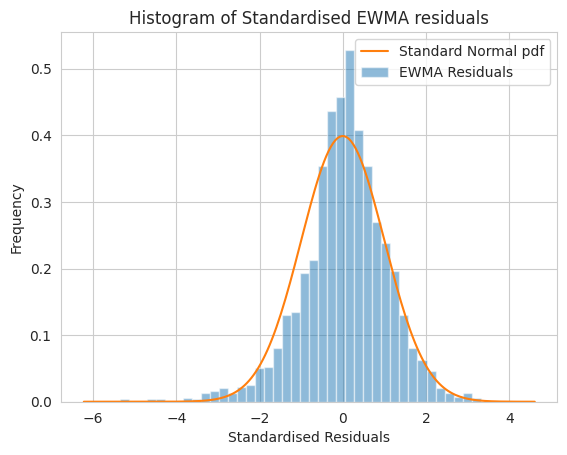

In [ ]:
#histogram of standardised ewma residuals
data2['stand_res'] = (data2['loss']-mu_t)/data2['ewma_volatility']
_, bins, _ = plt.hist(data2['stand_res'], bins=50, alpha=0.5, density=True)

xs3 = np.linspace(bins[0], bins[-1], 200)
ys3 = norm.pdf(xs3, loc=0, scale=1)
plt.plot(xs3,ys3)

plt.title('Histogram of Standardised EWMA residuals')
plt.legend(['Standard Normal pdf', 'EWMA Residuals'])
plt.xlabel('Standardised Residuals')
plt.ylabel('Frequency')
plt.show()

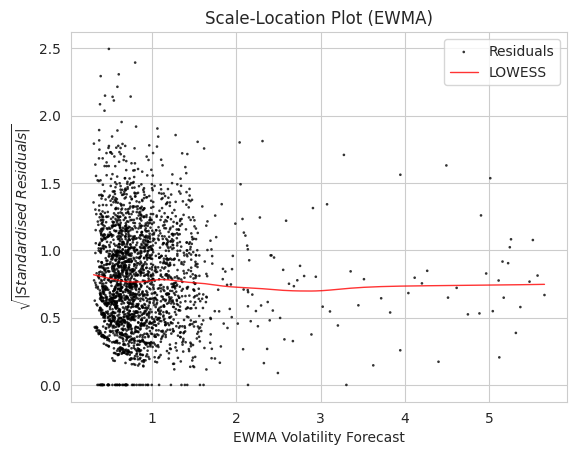

In [ ]:
sns.regplot(x=data2['ewma_volatility'], y=np.sqrt(abs(data2['stand_res'])),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (EWMA)')
plt.xlabel('EWMA Volatility Forecast')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS'])
plt.show()

Text(0, 0.5, 'Autocorrelation')

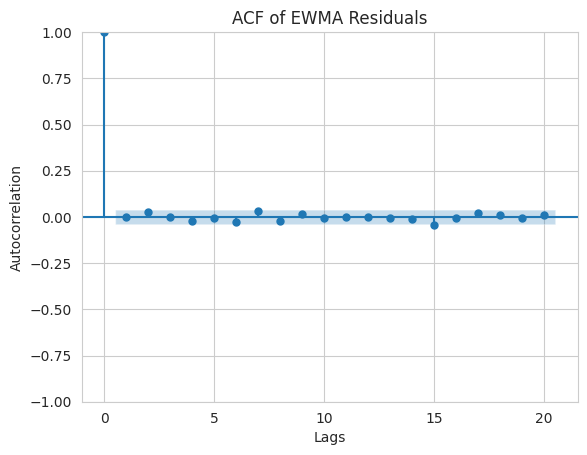

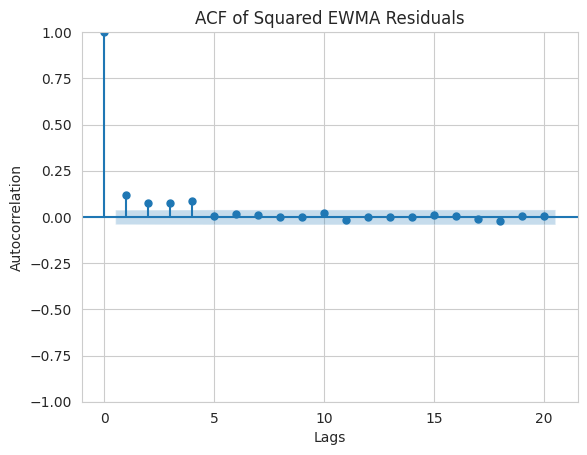

In [ ]:
plot_acf(data2['stand_res'], lags=20)
plt.title('ACF of EWMA Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plot_acf(data2['stand_res']**2, lags=20)
plt.title('ACF of Squared EWMA Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

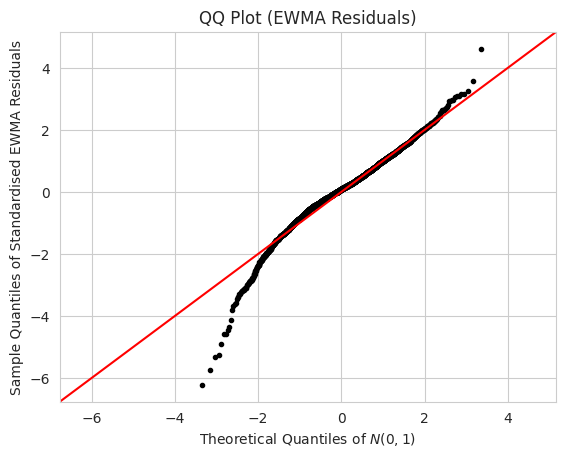

In [ ]:
#extreme values more frequent in the data than would be expected under a normal distribution
#curvature away from the line suggests the presence of skewness or kurtosis
qqplot(data2['stand_res'], norm, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('QQ Plot (EWMA Residuals)')
plt.xlabel(r'Theoretical Quantiles of $N(0, 1)$');
plt.ylabel('Sample Quantiles of Standardised EWMA Residuals')
plt.show()

In [ ]:
# applying historical simulation to the standardised EWMA residuals, within a rolling window over the past 500 trading days.

confidence_levels = [0.95, 0.99]
rolling_window = 500

for t in range(rolling_window, len(data2)):
    window_data = data2['stand_res'].iloc[t-rolling_window:t]

    for level in confidence_levels:
        var_quantile = np.quantile(window_data,level)

        es_values = window_data[window_data >= var_quantile]
        es_mean = es_values.mean()

        ewma_volatility = data2['ewma_volatility'].iloc[t]
        data2.loc[data2.index[t], f'ewma_VaR_{int(level*100)}'] = ewma_volatility * var_quantile
        data2.loc[data2.index[t], f'ewma_ES_{int(level*100)}'] = ewma_volatility * es_mean

data2[['log_return', 'ewma_volatility', 'ewma_VaR_95', 'ewma_ES_95', 'ewma_VaR_99', 'ewma_ES_99']].iloc[498:503]

,log_return,ewma_volatility,ewma_VaR_95,ewma_ES_95,ewma_VaR_99,ewma_ES_99
Date,,,,,,
2015-10-23,-0.972184,1.086812,NaN,NaN,NaN,NaN
2015-10-26,0.177491,1.080278,NaN,NaN,NaN,NaN
2015-10-27,0.265597,1.048270,1.659031,2.177400,2.349842,2.911106
2015-10-28,-1.200814,1.018416,1.611783,2.115388,2.282919,2.828199
2015-10-29,0.134129,1.030271,1.630545,2.140013,2.309494,2.861121


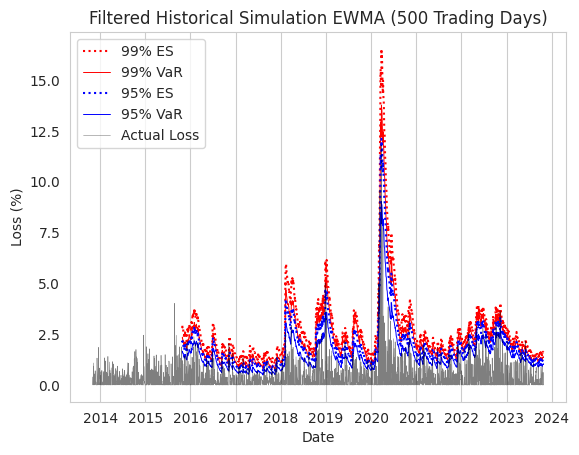

In [ ]:
plt.plot(data2['ewma_ES_99'], c='r', linestyle=':')
plt.plot(data2['ewma_VaR_99'], c='r', linewidth=0.7)
plt.plot(data2['ewma_ES_95'], c='b', linestyle=':')
plt.plot(data2['ewma_VaR_95'], c='b', linewidth=0.7)
plt.plot(np.maximum(data2['loss'], 0), c='k', linewidth=0.4, alpha=0.5)
plt.title('Filtered Historical Simulation EWMA (500 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Loss (%)')
plt.legend(['99% ES', '99% VaR', '95% ES', '95% VaR', 'Actual Loss'], loc=2)
plt.grid(axis='y')

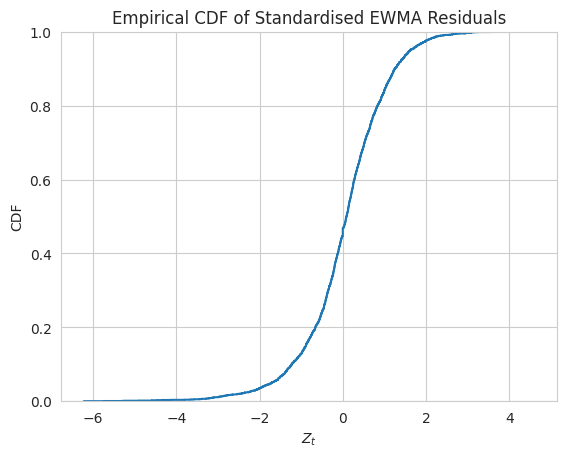

In [ ]:
sorted_residuals = sorted(data2['stand_res'])
plt.ecdf(sorted_residuals)
plt.title('Empirical CDF of Standardised EWMA Residuals')
plt.ylabel('CDF')
plt.xlabel(r'$Z_t$')
plt.show()

(iii) FHS with Garch

In [ ]:
loss = data2['loss'].to_frame(name='loss')

window_size = 500
confidence_levels = [0.95, 0.99]

for conf in confidence_levels:
    loss.loc[:, f'res_VaR_{int(conf*100)}'] = np.NaN
    loss.loc[:, f'res_ES_{int(conf*100)}'] = np.NaN

rolling_fitted_vol = []
standardized_garch_residuals = []
fitted_means = []
forecast_vols = []


for t in range(window_size, len(loss)):
    window_data = loss['loss'].iloc[t - window_size:t]

    model = arch_model(window_data)
    model_fit = model.fit(disp="off")
    params = model_fit.params

    garch_fitted_vol = np.array(model_fit.conditional_volatility)
    rolling_fitted_vol.append(garch_fitted_vol[-1])
    residual = np.array(model_fit.resid)

    standardized_residual = residual / garch_fitted_vol
    standardized_garch_residuals.append(standardized_residual[-1])
    fitted_mean = loss['loss'].iloc[t-1]-residual[-1]
    forecast_vol = math.sqrt(params['omega'] + params['alpha[1]']*(residual[-1]**2) + params['beta[1]']*(garch_fitted_vol[-1]**2))
    fitted_means.append(fitted_mean)
    forecast_vols.append(forecast_vol)

    for conf in confidence_levels:
        res_VaR = np.quantile(standardized_residual, conf)
        loss.loc[loss.index[t], f'res_VaR_{int(conf*100)}'] = res_VaR
        loss.loc[loss.index[t], f'res_ES_{int(conf*100)}'] = standardized_residual[standardized_residual >= res_VaR].mean()


rolling_fitted_vol = [np.nan] * window_size + rolling_fitted_vol
standardized_garch_residuals = [np.nan] * window_size + standardized_garch_residuals
fitted_means = [np.nan] * window_size + fitted_means
forecast_vols = [np.nan] * window_size + forecast_vols

In [ ]:
loss['garch_fitted_vol'] = rolling_fitted_vol
loss['standardized_garch_residuals'] = standardized_garch_residuals
loss['fitted_mean'] = fitted_means
loss['forecast_vol'] = forecast_vols

mean_residual = np.nanmean(loss['standardized_garch_residuals'])
std_residual = np.nanstd(loss['standardized_garch_residuals'])

print(f"Mean of standardized residuals: {mean_residual}")
print(f"Standard deviation of standardized residuals: {std_residual}")

Mean of standardized residuals: -0.06042694878961593
Standard deviation of standardized residuals: 0.9999437283516998


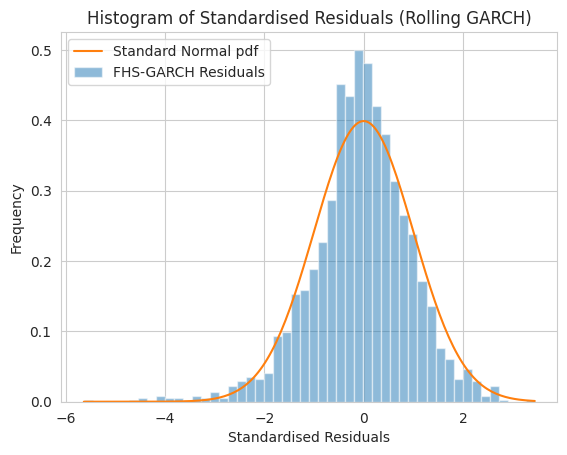

In [ ]:
#histogram of standardised garch residuals
_, bins, _ = plt.hist(loss['standardized_garch_residuals'], bins=50, alpha=0.5, density=True)

xs4 = np.linspace(bins[0], bins[-1], 200)
ys4 = norm.pdf(xs4, loc=0, scale=1)
plt.plot(xs4, ys4)

plt.title('Histogram of Standardised Residuals (Rolling GARCH)')
plt.legend(['Standard Normal pdf', 'FHS-GARCH Residuals'])
plt.xlabel('Standardised Residuals')
plt.ylabel('Frequency')
plt.show()

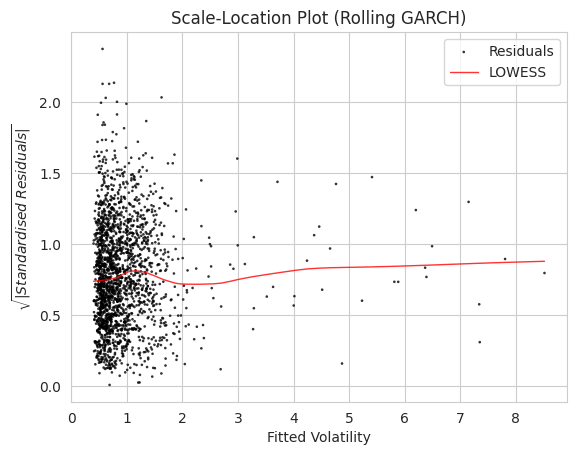

In [ ]:
sns.regplot(x=loss['garch_fitted_vol'], y=np.sqrt(abs(loss['standardized_garch_residuals'])),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (Rolling GARCH)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$');
plt.legend(['Residuals', 'LOWESS'])
plt.show()

Text(0, 0.5, 'Autocorrelation')

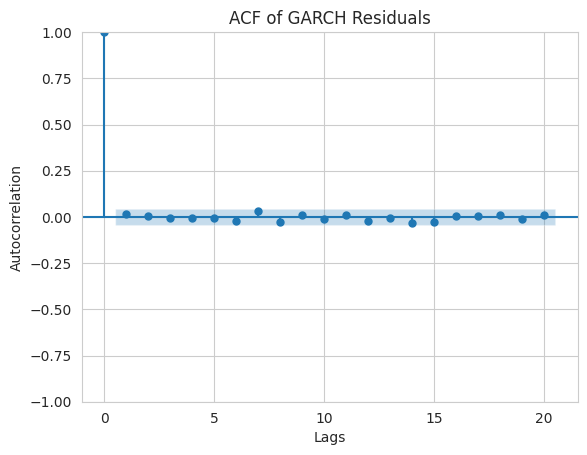

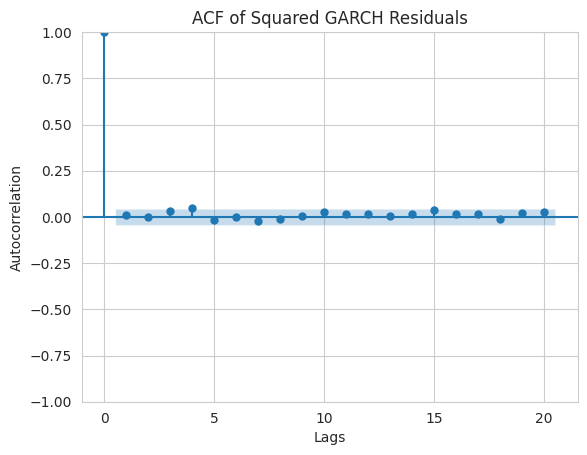

In [ ]:
plot_acf(loss['standardized_garch_residuals'].dropna(), lags=20)
plt.title('ACF of GARCH Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

plot_acf(loss['standardized_garch_residuals'].dropna()**2, lags=20)
plt.title('ACF of Squared GARCH Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

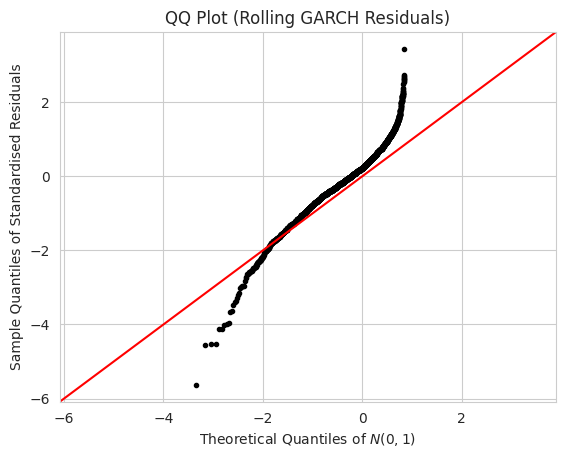

In [ ]:
qqplot(loss['standardized_garch_residuals'], norm, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('QQ Plot (Rolling GARCH Residuals)')
plt.xlabel(r'Theoretical Quantiles of $N(0, 1)$');
plt.ylabel('Sample Quantiles of Standardised Residuals')
plt.show()

In [ ]:
confidence_levels = [0.95, 0.99]
rolling_window = 500

for conf in confidence_levels:
    loss[f'return_VaR_{int(conf*100)}'] = loss['fitted_mean'] + loss['forecast_vol']*loss[f'res_VaR_{int(conf*100)}']
    loss[f'return_ES_{int(conf*100)}'] = loss['fitted_mean'] + loss['forecast_vol']*loss[f'res_ES_{int(conf*100)}']

print(loss.iloc[498:503])

                loss  res_VaR_95  res_ES_95  res_VaR_99  res_ES_99  \
Date                                                                 
2015-10-23  0.972184         NaN        NaN         NaN        NaN   
2015-10-26 -0.177491         NaN        NaN         NaN        NaN   
2015-10-27 -0.265597    1.435791   1.881629    2.197833   2.495664   
2015-10-28  1.200814    1.431989   1.881017    2.192859   2.494518   
2015-10-29 -0.134129    1.436998   1.876115    2.191271   2.490741   

            garch_fitted_vol  standardized_garch_residuals  fitted_mean  \
Date                                                                      
2015-10-23               NaN                           NaN          NaN   
2015-10-26               NaN                           NaN          NaN   
2015-10-27          0.952229                     -0.264625     0.074493   
2015-10-28          0.851829                     -0.400528     0.075584   
2015-10-29          0.779266                      1.443466 

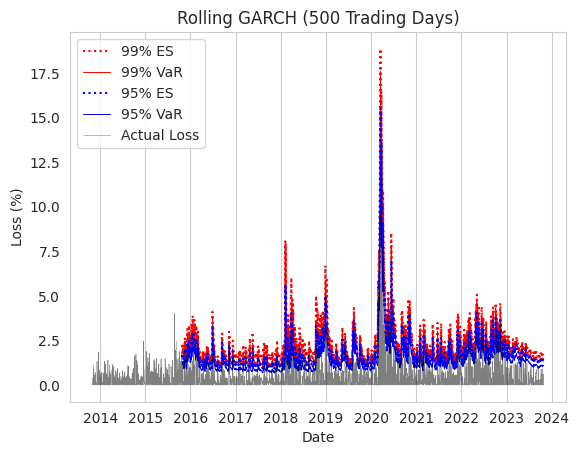

In [ ]:
plt.plot(loss['return_ES_99'], c='r', linestyle=':')
plt.plot(loss['return_VaR_99'], c='r', linewidth=0.7)
plt.plot(loss['return_ES_95'], c='b', linestyle=':')
plt.plot(loss['return_VaR_95'], c='b', linewidth=0.7)
plt.plot(np.maximum(loss['loss'], 0), c='k', linewidth=0.4, alpha=0.5)
plt.title('Rolling GARCH (500 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Loss (%)')
plt.legend(['99% ES', '99% VaR', '95% ES', '95% VaR', 'Actual Loss'], loc=2)
plt.grid(axis='y')

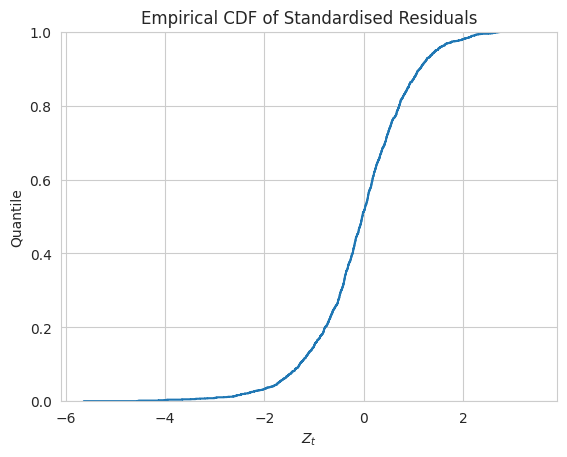

In [ ]:
garch_sorted_residuals = sorted(loss['standardized_garch_residuals'].dropna())
plt.ecdf(garch_sorted_residuals);
plt.title('Empirical CDF of Standardised Residuals')
plt.ylabel('Quantile')
plt.xlabel(r'$Z_t$')
plt.show()

Backtesting

In [ ]:
data2

,Adj Close,log_return,loss,var95,var99,es95,es99,ewma_variance,ewma_volatility,stand_res,ewma_VaR_95,ewma_ES_95,ewma_VaR_99,ewma_ES_99
Date,,,,,,,,,,,,,,
2013-10-31,105.823196,0.357670,-0.357670,NaN,NaN,NaN,NaN,1.190289,1.091004,-0.327836,NaN,NaN,NaN,NaN
2013-11-01,105.407578,-0.393521,0.393521,NaN,NaN,NaN,NaN,1.126548,1.061389,0.370760,NaN,NaN,NaN,NaN
2013-11-04,105.256462,-0.143466,0.143466,NaN,NaN,NaN,NaN,1.068246,1.033560,0.138808,NaN,NaN,NaN,NaN
2013-11-05,105.407578,0.143466,-0.143466,NaN,NaN,NaN,NaN,1.005386,1.002690,-0.143082,NaN,NaN,NaN,NaN
2013-11-06,104.463081,-0.900081,0.900081,NaN,NaN,NaN,NaN,0.946298,0.972779,0.925269,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,34.049999,0.618647,-0.618647,1.731372,2.730395,2.302237,3.01516,0.407845,0.638628,-0.968713,1.030126,1.304471,1.378055,1.632144
2023-10-24,33.840000,-0.618647,0.618647,1.731372,2.730395,2.302237,3.01516,0.406338,0.637446,0.970508,1.028221,1.302058,1.375506,1.629126
2023-10-25,33.959999,0.353980,-0.353980,1.731372,2.730395,2.302237,3.01516,0.404921,0.636334,-0.556280,1.026427,1.299786,1.373106,1.626283


In [ ]:
#historical backtest
#unconditional coverage

from scipy.stats import chi2

alpha1 = 0.95
alpha2 = 0.99

losses = loss['loss']
var_95_forecasts = data2['var95']
var_99_forecasts = data2['var99']


var_95_violations = (losses > var_95_forecasts).astype(int)
var_99_violations = (losses > var_99_forecasts).astype(int)


T_95 = len(var_95_violations)
T_99 = len(var_99_violations)

N_95 = var_95_violations.sum()
N_99 = var_99_violations.sum()
print(N_95, N_99)

pi_hat_95 = N_95 / (T_95-500)
pi_hat_99 = N_99 / (T_99-500)

expected_violations_95 = alpha1
expected_violations_99 = alpha2


L_H0_95 = (T_95-500 - N_95) * (np.log(alpha1)) + N_95 * np.log(1-alpha1)
L_H0_99 = (T_99-500 - N_99) * (np.log(alpha2)) + N_99 * np.log(1-alpha2)

L_H1_95 = (T_95-500 - N_95) * np.log(1 - pi_hat_95) + N_95 * np.log(pi_hat_95)
L_H1_99 = (T_99-500 - N_99) * np.log(1 - pi_hat_99) + N_99 * np.log(pi_hat_99)


LR_uc_95 = -2 * (L_H0_95 - L_H1_95)
LR_uc_99 = -2 * (L_H0_99 - L_H1_99)
LR_uc_95_hist = LR_uc_95
LR_uc_99_hist = LR_uc_99

p_value_95 = 1 - chi2.cdf(LR_uc_95, df=1)
p_value_99 = 1 - chi2.cdf(LR_uc_99, df=1)


print("Unconditional Coverage Test Results:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95:.4f}")
print(f"p-value: {p_value_95:.4f}")


print(f"\nLikelihood Ratio (LR_uc): {LR_uc_99:.4f}")
print(f"p-value: {p_value_99:.4f}")



99 30
Unconditional Coverage Test Results:
Likelihood Ratio (LR_uc): 0.0322
p-value: 0.8576

Likelihood Ratio (LR_uc): 4.2283
p-value: 0.0398


In [ ]:
#filtered historical backtest
#unconditional coverage

alpha1 = 0.95
alpha2=0.99

losses = loss['loss']
var_95_forecasts = data2['ewma_VaR_95']
var_99_forecasts = data2['ewma_VaR_99']


var_95_violations = (losses > var_95_forecasts).astype(int)
var_99_violations = (losses > var_99_forecasts).astype(int)


T_95 = len(var_95_violations)
T_99 = len(var_99_violations)

N_95 = var_95_violations.sum()
N_99 = var_99_violations.sum()
print(N_95, N_99)

pi_hat_95 = N_95 / (T_95-500)
pi_hat_99 = N_99 / (T_99-500)

expected_violations_95 = alpha1
expected_violations_99 = alpha2


L_H0_95 = (T_95-500 - N_95) * (np.log(alpha1)) + N_95 * np.log(1-alpha1)
L_H0_99 = (T_99-500 - N_99) * (np.log(alpha2)) + N_99 * np.log(1-alpha2)

L_H1_95 = (T_95-500 - N_95) * np.log(1 - pi_hat_95) + N_95 * np.log(pi_hat_95)
L_H1_99 = (T_99-500 - N_99) * np.log(1 - pi_hat_99) + N_99 * np.log(pi_hat_99)


LR_uc_95 = -2 * (L_H0_95 - L_H1_95)
LR_uc_99 = -2 * (L_H0_99 - L_H1_99)
LR_uc_95_filtered = LR_uc_95
LR_uc_99_filtered = LR_uc_99

p_value_95 = 1 - chi2.cdf(LR_uc_95, df=1)
p_value_99 = 1 - chi2.cdf(LR_uc_99, df=1)


print("Unconditional Coverage Test Results:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95:.4f}")
print(f"p-value: {p_value_95:.4f}")
if p_value_95 < 0.05:
    print(" The model does not provide accurate VaR forecasts.")
else:
    print(" The model provides accurate VaR forecasts.")

print(f"\nLikelihood Ratio (LR_uc): {LR_uc_99:.4f}")
print(f"p-value: {p_value_99:.4f}")
if p_value_99 < 0.05:
    print(" The model does not provide accurate VaR forecasts.")
else:
    print(" The model provides accurate VaR forecasts.")

99 23
Unconditional Coverage Test Results:
Likelihood Ratio (LR_uc): 0.0322
p-value: 0.8576
 The model provides accurate VaR forecasts.

Likelihood Ratio (LR_uc): 0.3894
p-value: 0.5326
 The model provides accurate VaR forecasts.


In [ ]:
#filtered historical with Garch backtest
#unconditional coverage

alpha1 = 0.95
alpha2=0.99

losses = loss['loss']
var_95_forecasts = loss['return_VaR_95']
var_99_forecasts = loss['return_VaR_99']


var_95_violations = (losses > var_95_forecasts).astype(int)
var_99_violations = (losses > var_99_forecasts).astype(int)


T_95 = len(var_95_violations)
T_99 = len(var_99_violations)

N_95 = var_95_violations.sum()
N_99 = var_99_violations.sum()
print(N_95, N_99)

pi_hat_95 = N_95 / (T_95-500)
pi_hat_99 = N_99 / (T_99-500)

expected_violations_95 = alpha1
expected_violations_99 = alpha2


L_H0_95 = (T_95-500 - N_95) * (np.log(alpha1)) + N_95 * np.log(1-alpha1)
L_H0_99 = (T_99-500 - N_99) * (np.log(alpha2)) + N_99 * np.log(1-alpha2)

L_H1_95 = (T_95-500 - N_95) * np.log(1 - pi_hat_95) + N_95 * np.log(pi_hat_95)
L_H1_99 = (T_99-500 - N_99) * np.log(1 - pi_hat_99) + N_99 * np.log(pi_hat_99)


LR_uc_95 = -2 * (L_H0_95 - L_H1_95)
LR_uc_99 = -2 * (L_H0_99 - L_H1_99)
LR_uc_95_garch = LR_uc_95
LR_uc_99_garch = LR_uc_99


p_value_95 = 1 - chi2.cdf(LR_uc_95, df=1)
p_value_99 = 1 - chi2.cdf(LR_uc_99, df=1)


print("Unconditional Coverage Test Results:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95:.4f}")
print(f"p-value: {p_value_95:.4f}")
if p_value_95 < 0.05:
    print(" The model does not provide accurate VaR forecasts.")
else:
    print(" The model provides accurate VaR forecasts.")

print(f"\nLikelihood Ratio (LR_uc): {LR_uc_99:.4f}")
print(f"p-value: {p_value_99:.4f}")
if p_value_99 < 0.05:
    print(" The model does not provide accurate VaR forecasts.")
else:
    print(" The model provides accurate VaR forecasts.")

101 29
Unconditional Coverage Test Results:
Likelihood Ratio (LR_uc): 0.0007
p-value: 0.9796
 The model provides accurate VaR forecasts.

Likelihood Ratio (LR_uc): 3.4566
p-value: 0.0630
 The model provides accurate VaR forecasts.


In [ ]:
#joint coverage historical backtest

alpha1 = 0.95
alpha2 = 0.99

losses = data2['loss']
var_95_forecasts = data2['var95']
var_99_forecasts = data2['var99']

var_95_violations = (losses > var_95_forecasts).astype(int).iloc[500:]
var_99_violations = (losses > var_99_forecasts).astype(int).iloc[500:]

var_95_violations_lagged = var_95_violations.shift(1)
var_99_violations_lagged = var_99_violations.shift(1)

T00_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 0)).sum()
T01_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 1)).sum()
T10_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 0)).sum()
T11_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 1)).sum()

T00_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 0)).sum()
T01_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 1)).sum()
T10_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 0)).sum()
T11_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 1)).sum()

pi_01_95 = T01_95 / (T00_95 + T01_95)
pi_11_95 = T11_95 / (T10_95 + T11_95)
pi_hat_95 = var_95_violations.mean()

pi_01_99 = T01_99 / (T00_99 + T01_99)
pi_11_99 = T11_99 / (T10_99 + T11_99)
pi_hat_99 = var_99_violations.mean()

log_L_H0_95 = (T00_95 + T10_95) * np.log(1 - pi_hat_95) + (T01_95 + T11_95) * np.log(pi_hat_95)
log_L_H0_99 = (T00_99 + T10_99) * np.log(1 - pi_hat_99) + (T01_99 + T11_99) * np.log(pi_hat_99)


log_L_H1_95 = T00_95 * np.log(1 - pi_01_95) + T01_95 * np.log(pi_01_95) + \
           T10_95 * np.log(1 - pi_11_95) + T11_95 * np.log(pi_11_95)
log_L_H1_99 = T00_99 * np.log(1 - pi_01_99) + T01_99 * np.log(pi_01_99) + \
           T10_99 * np.log(1 - pi_11_99) + T11_99 * np.log(pi_11_99)


LR_ind_95 = -2 * (log_L_H0_95 - log_L_H1_95)
LR_ind_99 = -2 * (log_L_H0_99 - log_L_H1_99)


LR_joint_95 = LR_uc_95_hist + LR_ind_95
LR_joint_99 = LR_uc_99_hist + LR_ind_99


p_value_joint_95 = 1 - chi2.cdf(LR_joint_95, df=2)
p_value_joint_99 = 1 - chi2.cdf(LR_joint_99, df=2)


print("Joint Test for alpha = 0.95:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95_hist:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_95:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_95:.4f}")
print(f"p-value: {p_value_joint_95:.4f}")


print("Joint Test for alpha = 0.99:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_99_hist:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_99:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_99:.4f}")
print(f"p-value: {p_value_joint_99:.4f}")


Joint Test for alpha = 0.95:
Likelihood Ratio (LR_uc): 0.0322
Likelihood Ratio (LR_ind): 4.7222
Likelihood Ratio (LR_joint): 4.7544
p-value: 0.0928
Joint Test for alpha = 0.99:
Likelihood Ratio (LR_uc): 4.2283
Likelihood Ratio (LR_ind): 3.0557
Likelihood Ratio (LR_joint): 7.2840
p-value: 0.0262


In [ ]:
#joint coverage filtered historical backtest

alpha1 = 0.95
alpha2 = 0.99

losses = loss['loss']
var_95_forecasts = data2['ewma_VaR_95']
var_99_forecasts = data2['ewma_VaR_99']
var_95_violations = (losses > var_95_forecasts).astype(int).iloc[500:]
var_99_violations = (losses > var_99_forecasts).astype(int).iloc[500:]

var_95_violations_lagged = var_95_violations.shift(1)
var_99_violations_lagged = var_99_violations.shift(1)

T00_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 0)).sum()
T01_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 1)).sum()
T10_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 0)).sum()
T11_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 1)).sum()

T00_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 0)).sum()
T01_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 1)).sum()
T10_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 0)).sum()
T11_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 1)).sum()

pi_01_95 = T01_95 / (T00_95 + T01_95)
pi_11_95 = T11_95 / (T10_95 + T11_95)
pi_hat_95 = var_95_violations.mean()

pi_01_99 = T01_99 / (T00_99 + T01_99)
pi_11_99 = T11_99 / (T10_99 + T11_99)
pi_hat_99 = var_99_violations.mean()


log_L_H0_95 = (T00_95 + T10_95) * np.log(1 - pi_hat_95) + (T01_95 + T11_95) * np.log(pi_hat_95)
log_L_H0_99 = (T00_99 + T10_99) * np.log(1 - pi_hat_99) + (T01_99 + T11_99) * np.log(pi_hat_99)


log_L_H1_95 = T00_95 * np.log(1 - pi_01_95) + T01_95 * np.log(pi_01_95) + \
           T10_95 * np.log(1 - pi_11_95) + T11_95 * np.log(pi_11_95)
log_L_H1_99 = T00_99 * np.log(1 - pi_01_99) + T01_99 * np.log(pi_01_99) + \
           T10_99 * np.log(1 - pi_11_99)


LR_ind_95 = -2 * (log_L_H0_95 - log_L_H1_95)
LR_ind_99 = -2 * (log_L_H0_99 - log_L_H1_99)


LR_joint_95 = LR_uc_95_filtered + LR_ind_95
LR_joint_99 = LR_uc_99_filtered + LR_ind_99


p_value_joint_95 = 1 - chi2.cdf(LR_joint_95, df=2)
p_value_joint_99 = 1 - chi2.cdf(LR_joint_99, df=2)


print("Joint Test with alpha = 0.95:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95_filtered:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_95:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_95:.4f}")
print(f"p-value: {p_value_joint_95:.4f}")
if p_value_joint_95 < 0.05:
    print(" The model fails the joint test for VaR.")
else:
    print(" The model passes the joint test for VaR.")

print("Joint Test with alpha = 0.99:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_99_hist:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_99:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_99:.4f}")
print(f"p-value: {p_value_joint_99:.4f}")


Joint Test with alpha = 0.95:
Likelihood Ratio (LR_uc): 0.0322
Likelihood Ratio (LR_ind): 0.1807
Likelihood Ratio (LR_joint): 0.2128
p-value: 0.8990
 The model passes the joint test for VaR.
Joint Test with alpha = 0.99:
Likelihood Ratio (LR_uc): 4.2283
Likelihood Ratio (LR_ind): 0.5314
Likelihood Ratio (LR_joint): 0.9208
p-value: 0.6310


In [ ]:
#joint coverage filtered garch historical backtest

alpha1 = 0.95
alpha2 = 0.99

losses = loss['loss']
var_95_forecasts = loss['return_VaR_95']
var_99_forecasts = loss['return_VaR_99']

var_95_violations = (losses > var_95_forecasts).astype(int).iloc[500:]
var_99_violations = (losses > var_99_forecasts).astype(int).iloc[500:]

var_95_violations_lagged = var_95_violations.shift(1)
var_99_violations_lagged = var_99_violations.shift(1)

T00_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 0)).sum()
T01_95 = ((var_95_violations_lagged == 0) & (var_95_violations == 1)).sum()
T10_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 0)).sum()
T11_95 = ((var_95_violations_lagged == 1) & (var_95_violations == 1)).sum()

T00_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 0)).sum()
T01_99 = ((var_99_violations_lagged == 0) & (var_99_violations == 1)).sum()
T10_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 0)).sum()
T11_99 = ((var_99_violations_lagged == 1) & (var_99_violations == 1)).sum()

pi_01_95 = T01_95 / (T00_95 + T01_95)
pi_11_95 = T11_95 / (T10_95 + T11_95)
pi_hat_95 = var_95_violations.mean()

pi_01_99 = T01_99 / (T00_99 + T01_99)
pi_11_99 = T11_99 / (T10_99 + T11_99)
pi_hat_99 = var_99_violations.mean()

log_L_H0_95 = (T00_95 + T10_95) * np.log(1 - pi_hat_95) + (T01_95 + T11_95) * np.log(pi_hat_95)
log_L_H0_99 = (T00_99 + T10_99) * np.log(1 - pi_hat_99) + (T01_99 + T11_99) * np.log(pi_hat_99)


log_L_H1_95 = T00_95 * np.log(1 - pi_01_95) + T01_95 * np.log(pi_01_95) + \
           T10_95 * np.log(1 - pi_11_95) + T11_95 * np.log(pi_11_95)
log_L_H1_99 = T00_99 * np.log(1 - pi_01_99) + T01_99 * np.log(pi_01_99) + \
           T10_99 * np.log(1 - pi_11_99)


LR_ind_95 = -2 * (log_L_H0_95 - log_L_H1_95)
LR_ind_99 = -2 * (log_L_H0_99 - log_L_H1_99)


LR_joint_95 = LR_uc_95_garch + LR_ind_95
LR_joint_99 = LR_uc_95_garch + LR_ind_99


p_value_joint_95 = 1 - chi2.cdf(LR_joint_95, df=2)
p_value_joint_99 = 1 - chi2.cdf(LR_joint_99, df=2)


print("Joint Test with alpha = 0.95:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_95_garch:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_95:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_95:.4f}")
print(f"p-value: {p_value_joint_95:.4f}")


print("Joint Test with alpha = 0.99:")
print(f"Likelihood Ratio (LR_uc): {LR_uc_99_hist:.4f}")
print(f"Likelihood Ratio (LR_ind): {LR_ind_99:.4f}")
print(f"Likelihood Ratio (LR_joint): {LR_joint_99:.4f}")
print(f"p-value: {p_value_joint_99:.4f}")



Joint Test with alpha = 0.95:
Likelihood Ratio (LR_uc): 0.0007
Likelihood Ratio (LR_ind): 2.6122
Likelihood Ratio (LR_joint): 2.6129
p-value: 0.2708
Joint Test with alpha = 0.99:
Likelihood Ratio (LR_uc): 4.2283
Likelihood Ratio (LR_ind): 0.8474
Likelihood Ratio (LR_joint): 0.8480
p-value: 0.6544


In [ ]:
losses_95 = data2[data2['loss'] >= data2['var95']]
es_diff = losses_95['loss']-losses_95['es95']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('HS 95%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))
print('-----------------------------------------')

losses_99 = data2[data2['loss'] >= data2['var99']]
es_diff = losses_99['loss']-losses_99['es99']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('HS 99%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))

HS 95%
Z statistic:  1.1248035907570058
p-value:  0.13033613626606666
-----------------------------------------
HS 99%
Z statistic:  1.7795688815882755
p-value:  0.0375732713475061


In [ ]:
losses_95 = data2[data2['loss'] >= data2['ewma_VaR_95']]
es_diff = losses_95['loss']-losses_95['ewma_ES_95']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('EWMA 95%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))
print('-----------------------------------------')

losses_99 = data2[data2['loss'] >= data2['ewma_VaR_99']]
es_diff = losses_99['loss']-losses_99['ewma_ES_99']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('EWMA 99%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))

EWMA 95%
Z statistic:  0.24883906628393462
p-value:  0.4017426354185668
-----------------------------------------
EWMA 99%
Z statistic:  -0.8104610947654857
p-value:  0.7911623916766524


In [ ]:
loss

,loss,res_VaR_95,res_ES_95,res_VaR_99,res_ES_99,garch_fitted_vol,standardized_garch_residuals,fitted_mean,forecast_vol,return_VaR_95,return_ES_95,return_VaR_99,return_ES_99
Date,,,,,,,,,,,,,
2013-10-31,-0.357670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-01,0.393521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-04,0.143466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-05,-0.143466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-06,0.900081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,-0.618647,1.593233,2.032201,2.152164,2.526437,0.698839,-1.200719,-0.021561,0.710980,1.111196,1.423293,1.508585,1.774685
2023-10-24,0.618647,1.602845,2.035262,2.159407,2.535541,0.699905,-0.849326,-0.024199,0.698252,1.094991,1.396927,1.483611,1.746247
2023-10-25,-0.353980,1.598045,2.030817,2.150909,2.529713,0.700368,0.911773,-0.019929,0.700725,1.099861,1.403115,1.487267,1.752704


In [ ]:
losses_95 = loss[loss['loss'] >= loss['return_VaR_95']]
es_diff = losses_95['loss']-loss['return_ES_95']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('FHS GARCH 95%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))
print('-----------------------------------------')

losses_99 = loss[loss['loss'] >= loss['return_VaR_99']]
es_diff = losses_99['loss']-loss['return_ES_99']
Z_stat = es_diff.sum()/np.sqrt((es_diff**2).sum())
print('FHS GARCH 99%')
print('Z statistic: ', Z_stat)
print('p-value: ', 1-norm.cdf(Z_stat))

FHS GARCH 95%
Z statistic:  0.8091472879129957
p-value:  0.20921521541845634
-----------------------------------------
FHS GARCH 99%
Z statistic:  -0.3091059890260601
p-value:  0.6213795482250314
